# Algoritmos de clustering

## Alunos

- João Vitor Vendemiato Fatoretto - 199944
- Natan Beltrão da Cunha Pevidor Carvalho - 184972

## Resumo

Neste projeto, implementamos dois algoritmos não-supervisionados de clustering: k-means e dbscan. Executamos os algoritmos em duas bases de dados: uma bidimensional fornecida no enunciado do projeto e uma fornecida pelo site Our World in Data de dados sobre COVID-19, disponível em https://ourworldindata.org/coronavirus.

In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd

## Dados bi-dimensionais

O primeiro passo foi separar os dados utilizados para treinamento dos modelos e os dados que serão usados para validação dos mesmos.

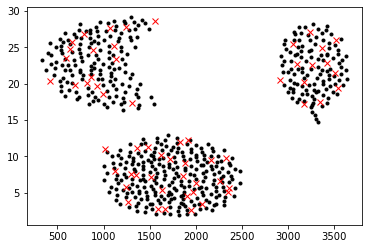

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

## K-means

Em seguida, implementamos o algoritmo k-means, que separa os dados em clusters caracterizados por um ponto central. Para inicializar o algoritmo, é necessário um parâmetro **k**, que determina quantos clusters diferentes serão gerados.

O primeiro passo é gerar **k** pontos para definirem os clusters inicialmente. Para isso, adotamos a inicialização da implementação k-means++. Nela, o primeiro ponto é escolhido aleatoriamente dentre os dados fornecidos e os próximos também são escolhidos de forma aleatória, porém com maior chance quantos mais distante estiver dos outros pontos já escolhidos.

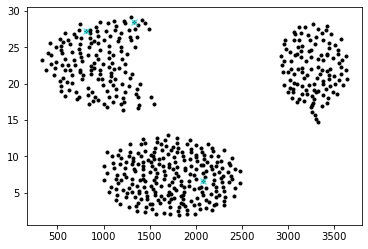

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(training, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

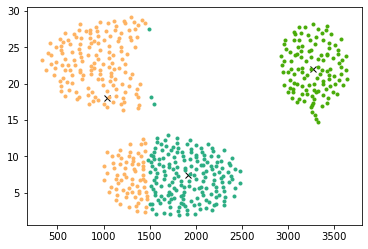

In [4]:
def get_cluster_data_kmeans(array, centers):
    distances = spsd.cdist(array, centers)
    clusterization = np.argmin(distances, axis=1)
    clusters = {}
    for i in range(centers.shape[0]):
        indices = np.where(clusterization == i)
        clusters[i] = np.take(array, indices, 0)
    return clusters

def kmeans(array, k, diff=0.1):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        clusters = get_cluster_data_kmeans(array, centers)
        
        new_centers = np.empty(centers.shape)
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], 1)
        
        if abs(np.sum(new_centers - centers)) > diff:
            centers = new_centers
        else:
            changed = False
    return centers

cluster_centers = kmeans(training, 3)
clusters = get_cluster_data_kmeans(training, cluster_centers)
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

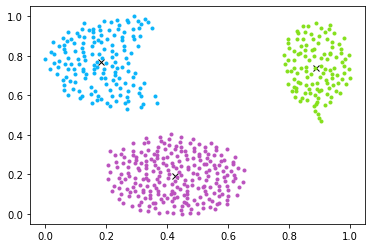

In [5]:
def normalize(array):
    min_by_feature = array.min(axis=0)
    max_by_feature = array.max(axis=0)
    
    for j in range(0, len(array[0])):
        for i in range(0, len(array)):
            array[i, j] = (array[i, j] - min_by_feature[j]) / (max_by_feature[j] - min_by_feature[j])
    
    return array

new_training = normalize(training)
new_centers = kmeans(new_training, 3, 0.0001)
new_clusters = get_cluster_data_kmeans(new_training, new_centers)

plot.plot(new_centers[:,0], new_centers[:,1], 'x', color='black')
for i in new_clusters:
    plot.plot(new_clusters[i][0,:,0], new_clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

## DBSCAN

A seguir implementamos o método dbscan, uma alternativa ao k-means para gerar a clusterização dos dados.

O método dbscan inicia separando os dados no centro de um cluster dos dados na borda. Para isso, precisamos informar dois parâmetros:

- **e**: o raio usado para decidir se dois pontos são vizinhos
- **m**: a quantidade de vizinhos necessária para que um ponto seja considerado central

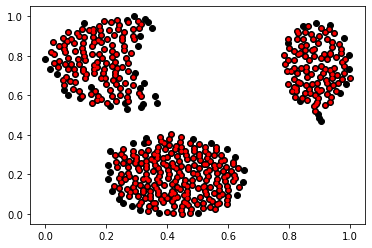

In [6]:
def get_core_points(array, e, m):
    cores = []
    distances = spsd.cdist(array, array)
    for i in range(distances.shape[0]):
        neighbors = np.where(distances[i] < e)
        if neighbors[0].size - 1 >= m:
            cores.append(array[i])
    return np.array(cores)

cores = get_core_points(new_training, 0.05, 6)

plot.plot(new_training[:,0], new_training[:,1], 'o', color='black')
plot.plot(cores[:,0], cores[:,1], '.', color='red')
plot.show()

Após testar alguns valores, optamos pelos valores 0.005 para **e** e 6 para **m**. Após isso, implementamos o restante do algoritmos do dbscan, que agrupa pontos centrais vizinhos em clusters.

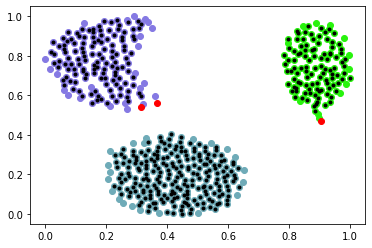

In [7]:
def get_cluster(clusters, core):
    for i in range(len(clusters)):
        for c in clusters[i]:
            if np.array_equal(c, core):
                return i
    return None

def add_core_to_cluster(clusters, cores, neighbors, core_index, cluster_index = None):
    if get_cluster(clusters, cores[core_index]) is not None:
        return
    
    if cluster_index is None:
        clusters.append([cores[core_index]])
        cluster_index = len(clusters) - 1
    else:
        clusters[cluster_index].append(cores[core_index])
    
    for i in range(neighbors[core_index].size):
        add_core_to_cluster(clusters, cores, neighbors, neighbors[core_index][i], cluster_index)

def dbscan(array, e, m):
    cores = get_core_points(array, e, m)
    distances = spsd.cdist(cores, cores)
    neighbors = []
    for i in range(distances.shape[0]):
        neighbors.append(np.where(distances[i] < e)[0])
    
    clusters = []
    for i in range(cores.shape[0]):
        add_core_to_cluster(clusters, cores, neighbors, i)
    
    for i in range(len(clusters)):
        clusters[i] = np.array(clusters[i])
    return clusters

def get_cluster_data_dbscan(array, cores, e):
    cluster_distances = []
    for i in range(len(cores)):
        distances = spsd.cdist(array, cores[i])
        cluster_distances.append(np.min(distances, axis=1))
    cluster_distances = np.array(cluster_distances)
    clusterization = np.argmin(cluster_distances, axis=0)
    
    clusters = {}
    outliers = []
    for i in range(len(cores)):
        clusters[i] = []
    
    for i in range(clusterization.size):
        if cluster_distances[clusterization[i],i] < e:
            clusters[clusterization[i]].append(array[i])
        else:
            outliers.append(array[i])
    
    for i in range(len(cores)):
        clusters[i] = np.array([clusters[i]])
    outliers = np.array(outliers)

    return (clusters, outliers)

cluster_cores = dbscan(new_training, 0.05, 6)
clusters, outliers = get_cluster_data_dbscan(new_training, cluster_cores, 0.05)

for i in range(len(clusters)):
    color = np.random.rand(3,)
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], 'o', color=color)
    plot.plot(cluster_cores[i][:,0], cluster_cores[i][:,1], '.', color='black')

if outliers.size:
    plot.plot(outliers[:,0], outliers[:,1], 'o', color='red')

plot.show()

In [8]:
import json

def covid_dataset_cleaner(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    matriz = {}
    notCountries = ["World", "Africa", "Europe", "European Union", "Asia", "North America", "South America", "Oceania", "International"]

    for country in data:
        if not (data[country]['location'] in notCountries):
            location = data[country]['location']
            newCountry = []
            
            lastMonth = str(data[country]['data'][0]['date'][5]) + str(data[country]['data'][0]['date'][6]) + '/' + str(data[country]['data'][0]['date'][2]) + str(data[country]['data'][0]['date'][3])
            lastData = []
            
            if lastMonth == '04/20':
                newCountry.append([0, '2020-03-31'])
            
            elif lastMonth == '05/20':
                newCountry.append([0, '2020-03-31'])
                newCountry.append([0, '2020-04-30'])

            for daysInformation in data[country]['data']:
                newMonth = str(daysInformation['date'][5]) + str(daysInformation['date'][6]) + '/' + str(daysInformation['date'][2]) + str(daysInformation['date'][3])

                if newMonth == '01/20' or newMonth == '02/20':
                    lastMonth = '03/20'
                    continue

                if lastMonth != newMonth:
                    newCountry.append(lastData)

                deaths = 0
                if 'total_deaths' in daysInformation:
                    deaths = daysInformation['total_deaths']

                lastMonth = newMonth
                lastData =  [deaths, daysInformation['date']]
                
            if len(newCountry) == 13:
                matriz[location] = newCountry
                
    # teste = []
    # for country in matriz:
        # print(country, ":", len(matriz[country]))
    

    return matriz


covid_dataset = covid_dataset_cleaner('covid-data.json')
print(covid_dataset)

{'Afghanistan': [[4.0, '2020-03-31'], [64.0, '2020-04-30'], [258.0, '2020-05-31'], [752.0, '2020-06-30'], [1284.0, '2020-07-31'], [1403.0, '2020-08-31'], [1460.0, '2020-09-30'], [1538.0, '2020-10-31'], [1795.0, '2020-11-30'], [2191.0, '2020-12-31'], [2400.0, '2021-01-31'], [2443.0, '2021-02-28'], [2484.0, '2021-03-31']], 'Albania': [[15.0, '2020-03-31'], [31.0, '2020-04-30'], [33.0, '2020-05-31'], [62.0, '2020-06-30'], [157.0, '2020-07-31'], [284.0, '2020-08-31'], [387.0, '2020-09-30'], [509.0, '2020-10-31'], [810.0, '2020-11-30'], [1181.0, '2020-12-31'], [1380.0, '2021-01-31'], [1796.0, '2021-02-28'], [2235.0, '2021-03-31']], 'Algeria': [[44.0, '2020-03-31'], [450.0, '2020-04-30'], [653.0, '2020-05-31'], [912.0, '2020-06-30'], [1210.0, '2020-07-31'], [1510.0, '2020-08-31'], [1736.0, '2020-09-30'], [1964.0, '2020-10-31'], [2431.0, '2020-11-30'], [2756.0, '2020-12-31'], [2891.0, '2021-01-31'], [2983.0, '2021-02-28'], [3093.0, '2021-03-31']], 'Andorra': [[12.0, '2020-03-31'], [42.0, '202